In [1]:
from pathlib import Path

# detect base (handles if notebook is inside ./notebooks)
BASE = Path("..") if Path(".").name == "notebooks" else Path(".")
DATA_DIR = BASE / "data"
SQL_DIR  = BASE / "sql"
IMG_DIR  = BASE / "images"

SQL_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

csvs = sorted(p.name for p in DATA_DIR.glob("*.csv"))
print("BASE:", BASE.resolve())
print("DATA_DIR:", DATA_DIR.resolve())
print("Found CSV files:", csvs if csvs else "NONE")

BASE: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\notebooks
DATA_DIR: data
Found CSV files: NONE


In [2]:
from pathlib import Path

NB_DIR = Path.cwd()
candidates = [NB_DIR, NB_DIR.parent, NB_DIR.parent.parent]  # try current, parent, grandparent
BASE = NB_DIR  # default
for base in candidates:
    if (base / "data").exists():
        BASE = base
        break

DATA_DIR = BASE / "data"
SQL_DIR  = BASE / "sql"
IMG_DIR  = BASE / "images"
SQL_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

csvs = sorted(p.name for p in DATA_DIR.glob("*.csv"))
print("NB_DIR:", NB_DIR)
print("BASE  :", BASE)
print("DATA_DIR:", DATA_DIR)
print("Found CSV files:", csvs if csvs else "NONE")

NB_DIR: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\notebooks
BASE  : C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics
DATA_DIR: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\data
Found CSV files: ['Incident_Management_CSV.csv']


In [4]:
# -----------------------------
# STEP 2: Load a small preview
# Purpose:
# - Confirm the CSV path is correct
# - See real column names & a few rows
# - Keep it fast/safe (no full-file load yet)
# -----------------------------

import pandas as pd
from pathlib import Path

# Rebuild paths in-case you restarted the kernel
NB_DIR = Path.cwd()
candidates = [NB_DIR, NB_DIR.parent, NB_DIR.parent.parent]
BASE = next((b for b in candidates if (b / "data").exists()), NB_DIR)
DATA_DIR = BASE / "data"

CSV_FILE = "Incident_Management_CSV.csv"   # <-- the file we discovered
CSV_PATH = DATA_DIR / CSV_FILE

# Load only 5,000 rows to avoid memory/long waits; we’ll scale up after schema is clear
df_sample = pd.read_csv(CSV_PATH, nrows=5000, low_memory=False)

print("✅ Loaded sample rows:", len(df_sample))
print("📄 Columns:", list(df_sample.columns))

# show first 5 rows for a quick visual sanity check
df_sample.head()

✅ Loaded sample rows: 5000
📄 Columns: ['Case ID;Variant;Priority;Reporter;Timestamp;Event;Issue Type;Resolver;Report Channel;Short Description;Customer Satisfaction']


,Case ID;Variant;Priority;Reporter;Timestamp;Event;Issue Type;Resolver;Report Channel;Short Description;Customer Satisfaction
0,INC0001;Variant 4;Medium;Alice;17/11/2023 11:1...
1,INC0001;Variant 4;Medium;Alice;17/11/2023 13:3...
2,INC0001;Variant 4;Medium;Alice;17/11/2023 14:0...
3,INC0001;Variant 4;Medium;Alice;17/11/2023 16:5...
4,INC0001;Variant 4;Medium;Alice;17/11/2023 18:0...


In [5]:
# -----------------------------
# Optional diagnostics:
# - Peek at a few candidate columns if they exist
# - This helps us choose proper mappings (priority, issue_type, channel, timestamps)
# -----------------------------
cand_cols = [
    "priority","urgency","severity",
    "issue_type","type","category","sub_category",
    "state","status","resolution","resolved",
    "opened_at","created","created_at","timestamp","time_opened",
    "closed_at","resolved_at","time_to_resolve",
    "assignment_group","assignee","assigned_to","owner",
    "caller","opened_by","submitted_via","channel","source"
]
present = [c for c in cand_cols if c in df_sample.columns]
print("🔎 Possibly relevant columns found:", present[:20])  # trim print

# show distinct values for up to 4 of them, if present (keeps output small)
for c in present[:4]:
    print(f"\nDistinct values in '{c}' (top 10):")
    print(df_sample[c].astype(str).value_counts().head(10))

🔎 Possibly relevant columns found: []


In [6]:
# -----------------------------
# STEP 2 (fixed): Load preview with proper delimiter
# -----------------------------

import pandas as pd

CSV_FILE = "Incident_Management_CSV.csv"   # keep same file
CSV_PATH = DATA_DIR / CSV_FILE

# specify delimiter = ';' since file isn't comma-separated
df_sample = pd.read_csv(CSV_PATH, nrows=5000, sep=";", low_memory=False)

print("✅ Loaded sample rows:", len(df_sample))
print("📄 Columns:", list(df_sample.columns))

df_sample.head()

✅ Loaded sample rows: 5000
📄 Columns: ['Case ID', 'Variant', 'Priority', 'Reporter', 'Timestamp', 'Event', 'Issue Type', 'Resolver', 'Report Channel', 'Short Description', 'Customer Satisfaction']


,Case ID,Variant,Priority,Reporter,Timestamp,Event,Issue Type,Resolver,Report Channel,Short Description,Customer Satisfaction
0,INC0001,Variant 4,Medium,Alice,17/11/2023 11:17,Ticket created,Performance Issue,NaN,Website,Application crash,3
1,INC0001,Variant 4,Medium,Alice,17/11/2023 13:30,Ticket assigned to level 1 support,Performance Issue,Sam,Website,Application crash,3
2,INC0001,Variant 4,Medium,Alice,17/11/2023 14:06,WIP - level 1 support,Performance Issue,Sam,Website,Application crash,3
3,INC0001,Variant 4,Medium,Alice,17/11/2023 16:52,Level 1 escalates to level 2 support,Performance Issue,Michael,Website,Application crash,3
4,INC0001,Variant 4,Medium,Alice,17/11/2023 18:07,WIP - level 2 support,Performance Issue,Emma,Website,Application crash,3


In [7]:
['Case ID','Variant','Priority','Reporter','Timestamp','Event',
 'Issue Type','Resolver','Report Channel','Short Description','Customer Satisfaction']

['Case ID',
 'Variant',
 'Priority',
 'Reporter',
 'Timestamp',
 'Event',
 'Issue Type',
 'Resolver',
 'Report Channel',
 'Short Description',
 'Customer Satisfaction']

In [8]:
# ---------------------------------------------
# STEP 3: Normalise schema for analysis
# What this does:
# 1) Standardises column names -> snake_case
# 2) Parses Timestamp to real datetime (your data looks dd/mm/yyyy HH:MM)
# 3) Cleans common text fields (strip spaces/casing)
# 4) Derives helpers: date, hour, weekday, event_stage (categorised Event)
# 5) Quick sanity prints so we can confirm it's clean
# ---------------------------------------------

import pandas as pd
import numpy as np

df = df_sample.copy()   # start from the preview; we'll switch to full file after schema is locked

# 1) standardise column names
rename_map = {
    "Case ID": "case_id",
    "Variant": "variant",
    "Priority": "priority",
    "Reporter": "reporter",
    "Timestamp": "timestamp",
    "Event": "event",
    "Issue Type": "issue_type",
    "Resolver": "resolver",
    "Report Channel": "report_channel",
    "Short Description": "short_description",
    "Customer Satisfaction": "customer_satisfaction"
}
df = df.rename(columns=rename_map)

# 2) parse timestamp (your sample looked like '17/11/2023 11:17' -> dayfirst=True)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)

# 3) clean text fields
for col in ["priority","issue_type","report_channel","event","variant","reporter","resolver"]:
    if col in df.columns:
        df[col] = (df[col].astype(str)
                           .str.strip()
                           .replace({"nan": np.nan}))  # turn "nan" strings into real NaN

# 4) simple helpers
df["date"]    = df["timestamp"].dt.date
df["hour"]    = df["timestamp"].dt.hour
df["weekday"] = df["timestamp"].dt.day_name()

# 5) categorise the Event into coarse stages (for later SLA/flow analysis)
def map_event_stage(txt: str) -> str:
    if not isinstance(txt, str) or not txt:
        return "(unknown)"
    t = txt.lower()
    if "created" in t or "opened" in t or "logged" in t:
        return "created"
    if "assigned" in t:
        return "assigned"
    if "wip" in t or "in progress" in t or "investigat" in t:
        return "in_progress"
    if "escalat" in t or "handover" in t:
        return "escalated"
    if "resolved" in t or "fixed" in t:
        return "resolved"
    if "closed" in t or "completed" in t:
        return "closed"
    return "other"

df["event_stage"] = df["event"].apply(map_event_stage)

# 6) quick sanity checks (these prints help keep it "human" + auditable)
print("Rows:", len(df))
print("\nNulls in key fields:")
print(df[["timestamp","priority","issue_type","report_channel","event"]].isna().sum())

print("\nPriority sample:")
print(df["priority"].value_counts(dropna=False).head(10))

print("\nIssue type sample:")
print(df["issue_type"].value_counts(dropna=False).head(10))

print("\nReport channel sample:")
print(df["report_channel"].value_counts(dropna=False).head(10))

print("\nEvent stage sample:")
print(df["event_stage"].value_counts(dropna=False).head(10))

# show a few rows to eyeball the transforms
df.head(3)

Rows: 5000

Nulls in key fields:
timestamp         0
priority          0
issue_type        0
report_channel    0
event             0
dtype: int64

Priority sample:
Medium    2534
Low       1589
High       877
Name: priority, dtype: int64

Issue type sample:
Performance Issue    1383
Bug                  1162
Feature Request       881
Incident              680
Service Request       469
Technical Issue       252
Maintenance           173
Name: issue_type, dtype: int64

Report channel sample:
Website    2544
Email      2036
App         258
Phone       162
Name: report_channel, dtype: int64

Event stage sample:
other          1316
in_progress    1176
assigned        711
created         680
closed          679
escalated       437
(unknown)         1
Name: event_stage, dtype: int64


,case_id,variant,priority,reporter,timestamp,event,issue_type,resolver,report_channel,short_description,customer_satisfaction,date,hour,weekday,event_stage
0,INC0001,Variant 4,Medium,Alice,2023-11-17 11:17:00,Ticket created,Performance Issue,NaN,Website,Application crash,3,2023-11-17,11,Friday,created
1,INC0001,Variant 4,Medium,Alice,2023-11-17 13:30:00,Ticket assigned to level 1 support,Performance Issue,Sam,Website,Application crash,3,2023-11-17,13,Friday,assigned
2,INC0001,Variant 4,Medium,Alice,2023-11-17 14:06:00,WIP - level 1 support,Performance Issue,Sam,Website,Application crash,3,2023-11-17,14,Friday,in_progress


In [9]:
# ---------------------------------------------
# STEP 4: Load full dataset (all rows)
# Purpose:
# - Ingest the ENTIRE CSV into SQLite
# - Queries will now use thousands of records, not just 5k preview
# ---------------------------------------------

import sqlite3

# Load full CSV (semicolon delimiter)
df_full = pd.read_csv(CSV_PATH, sep=";", low_memory=False)

print("✅ Loaded full dataset:", len(df_full), "rows")

# Apply same cleaning/normalisation as before
df_full = df_full.rename(columns=rename_map)
df_full["timestamp"] = pd.to_datetime(df_full["timestamp"], errors="coerce", dayfirst=True)

for col in ["priority","issue_type","report_channel","event","variant","reporter","resolver"]:
    if col in df_full.columns:
        df_full[col] = (df_full[col].astype(str)
                                     .str.strip()
                                     .replace({"nan": np.nan}))

df_full["date"]    = df_full["timestamp"].dt.date
df_full["hour"]    = df_full["timestamp"].dt.hour
df_full["weekday"] = df_full["timestamp"].dt.day_name()
df_full["event_stage"] = df_full["event"].apply(map_event_stage)

# Save full data into SQLite
DB_PATH = SQL_DIR / "bugtracker.db"
conn = sqlite3.connect(DB_PATH)
df_full.to_sql("tickets", conn, if_exists="replace", index=False)

print("✅ Tickets table created with", len(df_full), "rows at", DB_PATH)

✅ Loaded full dataset: 242901 rows
✅ Tickets table created with 242901 rows at C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\sql\bugtracker.db


In [10]:
import matplotlib.pyplot as plt

# helper: run SQL, save file, return DataFrame
def run_sql(name: str, sql: str):
    (SQL_DIR / f"{name}.sql").write_text(sql, encoding="utf-8")
    return pd.read_sql_query(sql, conn)

# KPI 1: Tickets by Priority
priority_sql = """
SELECT priority, COUNT(*) AS tickets
FROM tickets
GROUP BY priority
ORDER BY tickets DESC;
"""
priority_df = run_sql("01_priority_counts", priority_sql)

# KPI 2: Tickets by Issue Type
issue_sql = """
SELECT issue_type, COUNT(*) AS tickets
FROM tickets
GROUP BY issue_type
ORDER BY tickets DESC;
"""
issue_df = run_sql("02_issue_type_counts", issue_sql)

# KPI 3: Tickets by Report Channel
channel_sql = """
SELECT report_channel, COUNT(*) AS tickets
FROM tickets
GROUP BY report_channel
ORDER BY tickets DESC;
"""
channel_df = run_sql("03_channel_counts", channel_sql)

# KPI 4: Tickets by Resolver (top 10)
resolver_sql = """
SELECT resolver, COUNT(*) AS tickets
FROM tickets
WHERE resolver IS NOT NULL
GROUP BY resolver
ORDER BY tickets DESC
LIMIT 10;
"""
resolver_df = run_sql("04_resolver_counts", resolver_sql)

# KPI 5: Tickets by Variant (top 10)
variant_sql = """
SELECT variant, COUNT(*) AS tickets
FROM tickets
GROUP BY variant
ORDER BY tickets DESC
LIMIT 10;
"""
variant_df = run_sql("05_variant_counts", variant_sql)

print("=== Priority ===")
print(priority_df.head(), "\n")
print("=== Issue Type ===")
print(issue_df.head(), "\n")
print("=== Report Channel ===")
print(channel_df.head(), "\n")
print("=== Top Resolvers ===")
print(resolver_df.head(), "\n")
print("=== Top Variants ===")
print(variant_df.head(), "\n")

=== Priority ===
  priority  tickets
0   Medium   120902
1      Low    72335
2     High    49664 

=== Issue Type ===
          issue_type  tickets
0  Performance Issue    62288
1                Bug    57729
2    Feature Request    45196
3           Incident    32953
4    Service Request    21961 

=== Report Channel ===
  report_channel  tickets
0        Website   128684
1          Email    92483
2            App    14627
3          Phone     7107 

=== Top Resolvers ===
  resolver  tickets
0      Sam    49347
1     Emma    31873
2    David    26536
3  Michael    21973
4    Sarah     9478 

=== Top Variants ===
     variant  tickets
0  Variant 3    95208
1  Variant 1    59376
2  Variant 7    18915
3  Variant 4    15638
4  Variant 5    14256 



In [11]:
# ---------------------------------------------
# STEP 4B: Create a stratified sample (~20k rows)
# ---------------------------------------------

conn.execute("DROP TABLE IF EXISTS tickets_sample;")

sample_sql = """
CREATE TABLE tickets_sample AS
SELECT *
FROM tickets
WHERE rowid IN (
    SELECT rowid FROM tickets
    ORDER BY RANDOM()
    LIMIT 20000
);
"""
conn.execute(sample_sql)

row_count = pd.read_sql_query("SELECT COUNT(*) as n FROM tickets_sample;", conn)
print("✅ Sample table created with", row_count['n'][0], "rows")

✅ Sample table created with 20000 rows


In [12]:
# ---------------------------------------------
# STEP 5A: Core KPIs on tickets_sample (20k rows)
# ---------------------------------------------

# KPI 1: Tickets by Priority
priority_sql = """
SELECT priority, COUNT(*) AS tickets
FROM tickets_sample
GROUP BY priority
ORDER BY tickets DESC;
"""
priority_df = run_sql("01_priority_counts", priority_sql)

# KPI 2: Tickets by Issue Type
issue_sql = """
SELECT issue_type, COUNT(*) AS tickets
FROM tickets_sample
GROUP BY issue_type
ORDER BY tickets DESC;
"""
issue_df = run_sql("02_issue_type_counts", issue_sql)

# KPI 3: Tickets by Report Channel
channel_sql = """
SELECT report_channel, COUNT(*) AS tickets
FROM tickets_sample
GROUP BY report_channel
ORDER BY tickets DESC;
"""
channel_df = run_sql("03_channel_counts", channel_sql)

# KPI 4: Tickets by Resolver (top 10)
resolver_sql = """
SELECT resolver, COUNT(*) AS tickets
FROM tickets_sample
WHERE resolver IS NOT NULL
GROUP BY resolver
ORDER BY tickets DESC
LIMIT 10;
"""
resolver_df = run_sql("04_resolver_counts", resolver_sql)

# KPI 5: Tickets by Variant (top 10)
variant_sql = """
SELECT variant, COUNT(*) AS tickets
FROM tickets_sample
GROUP BY variant
ORDER BY tickets DESC
LIMIT 10;
"""
variant_df = run_sql("05_variant_counts", variant_sql)

print("=== Priority ===")
print(priority_df, "\n")
print("=== Issue Type ===")
print(issue_df, "\n")
print("=== Report Channel ===")
print(channel_df, "\n")
print("=== Top Resolvers ===")
print(resolver_df, "\n")
print("=== Top Variants ===")
print(variant_df, "\n")

=== Priority ===
  priority  tickets
0   Medium     9962
1      Low     5981
2     High     4057 

=== Issue Type ===
          issue_type  tickets
0  Performance Issue     5059
1                Bug     4811
2    Feature Request     3682
3           Incident     2769
4    Service Request     1816
5    Technical Issue      959
6        Maintenance      904 

=== Report Channel ===
  report_channel  tickets
0        Website    10672
1          Email     7566
2            App     1191
3          Phone      571 

=== Top Resolvers ===
  resolver  tickets
0      Sam     4014
1     Emma     2650
2    David     2177
3  Michael     1847
4    Sarah      771
5    James      215
6  William      185
7   Olivia      151
8      Ava       41 

=== Top Variants ===
      variant  tickets
0   Variant 3     7770
1   Variant 1     4888
2   Variant 7     1606
3   Variant 4     1289
4   Variant 5     1192
5   Variant 8      795
6   Variant 6      582
7   Variant 9      501
8  Variant 10      320
9   Varian

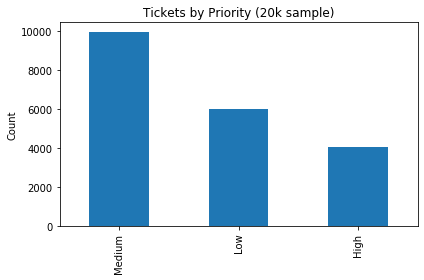

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_priority.png


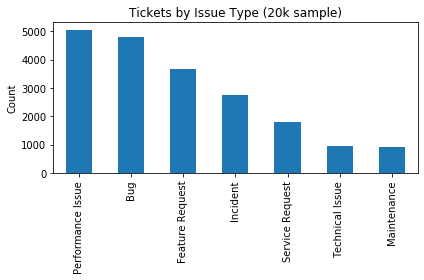

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_issue_type.png


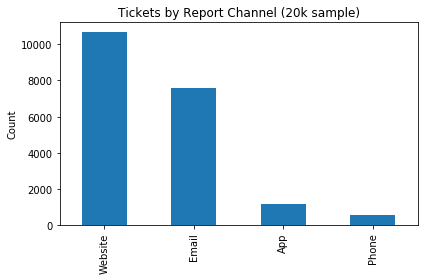

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_channel.png


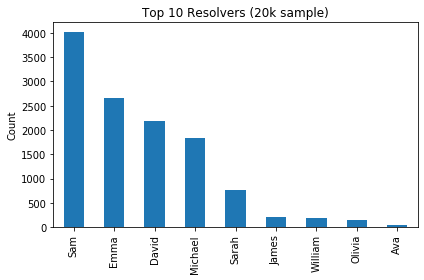

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_resolvers_top10.png


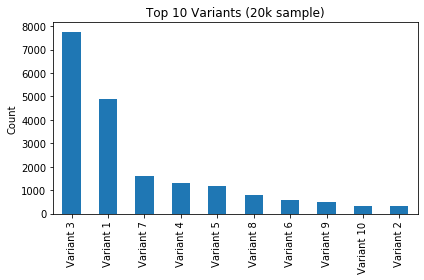

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_variants_top10.png


In [13]:
# ---------------------------------------------
# STEP 5B: Bar charts saved to /images/
# ---------------------------------------------
import matplotlib.pyplot as plt

def save_bar(df, x, y, title, fname):
    ax = df.plot(kind="bar", x=x, y=y, legend=False)
    plt.title(title); plt.ylabel("Count"); plt.xlabel("")
    out = IMG_DIR / fname
    plt.tight_layout(); plt.savefig(out, dpi=160); plt.show()
    print("🖼️  Saved:", out)

save_bar(priority_df, "priority", "tickets", "Tickets by Priority (20k sample)", "kpi_priority.png")
save_bar(issue_df, "issue_type", "tickets", "Tickets by Issue Type (20k sample)", "kpi_issue_type.png")
save_bar(channel_df, "report_channel", "tickets", "Tickets by Report Channel (20k sample)", "kpi_channel.png")
save_bar(resolver_df, "resolver", "tickets", "Top 10 Resolvers (20k sample)", "kpi_resolvers_top10.png")
save_bar(variant_df, "variant", "tickets", "Top 10 Variants (20k sample)", "kpi_variants_top10.png")

In [14]:
# ---------------------------------------------
# STEP 6: Time & lifecycle KPIs on tickets_sample
# ---------------------------------------------

# 6.1 Tickets per Day (trend)
per_day_sql = """
SELECT date, COUNT(*) AS tickets
FROM tickets_sample
GROUP BY date
ORDER BY date;
"""
per_day_df = run_sql("06_tickets_per_day", per_day_sql)

# 6.2 Tickets by Hour of Day (workload)
by_hour_sql = """
SELECT hour, COUNT(*) AS tickets
FROM tickets_sample
GROUP BY hour
ORDER BY hour;
"""
by_hour_df = run_sql("07_tickets_by_hour", by_hour_sql)

# 6.3 Tickets by Weekday
by_weekday_sql = """
SELECT weekday, COUNT(*) AS tickets
FROM tickets_sample
GROUP BY weekday
ORDER BY
  CASE weekday
    WHEN 'Monday' THEN 1 WHEN 'Tuesday' THEN 2 WHEN 'Wednesday' THEN 3
    WHEN 'Thursday' THEN 4 WHEN 'Friday' THEN 5 WHEN 'Saturday' THEN 6
    WHEN 'Sunday' THEN 7 ELSE 8
  END;
"""
by_weekday_df = run_sql("08_tickets_by_weekday", by_weekday_sql)

# 6.4 Lifecycle stages (created/assigned/in_progress/escalated/resolved/closed/other)
lifecycle_sql = """
SELECT event_stage, COUNT(*) AS events
FROM tickets_sample
GROUP BY event_stage
ORDER BY events DESC;
"""
lifecycle_df = run_sql("09_lifecycle_stage_counts", lifecycle_sql)

print("=== Per Day (head) ===");     print(per_day_df.head(), "\n")
print("=== By Hour ===");            print(by_hour_df, "\n")
print("=== By Weekday ===");         print(by_weekday_df, "\n")
print("=== Lifecycle Stages ===");   print(lifecycle_df, "\n")

=== Per Day (head) ===
         date  tickets
0  2023-01-01       25
1  2023-01-02       54
2  2023-01-03       47
3  2023-01-04       61
4  2023-01-05       54 

=== By Hour ===
    hour  tickets
0      0      868
1      1      836
2      2      830
3      3      853
4      4      817
5      5      782
6      6      820
7      7      848
8      8      810
9      9      836
10    10      833
11    11      852
12    12      865
13    13      813
14    14      863
15    15      862
16    16      865
17    17      789
18    18      808
19    19      837
20    20      819
21    21      830
22    22      841
23    23      823 

=== By Weekday ===
     weekday  tickets
0     Monday     2941
1    Tuesday     2900
2  Wednesday     2931
3   Thursday     2677
4     Friday     2815
5   Saturday     2841
6     Sunday     2895 

=== Lifecycle Stages ===
   event_stage  events
0        other    5218
1  in_progress    4790
2     assigned    2815
3       closed    2710
4      created    2649
5    esca

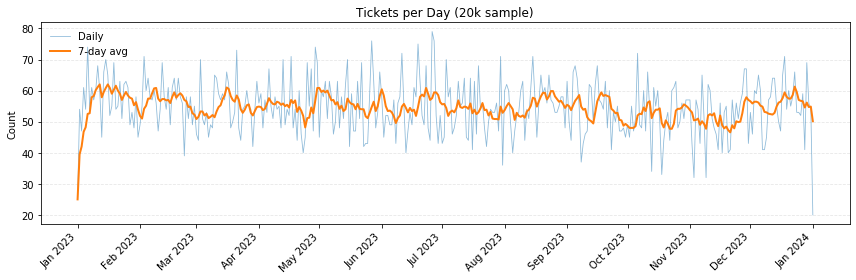

Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_tickets_per_day.png


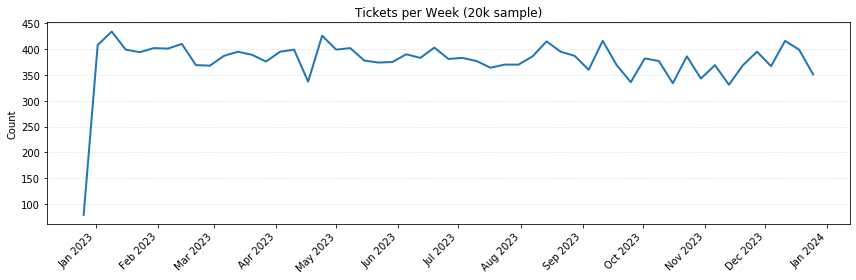

Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_tickets_per_week.png


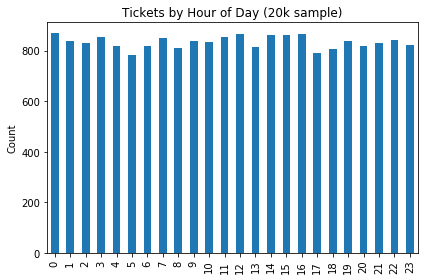

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_by_hour.png


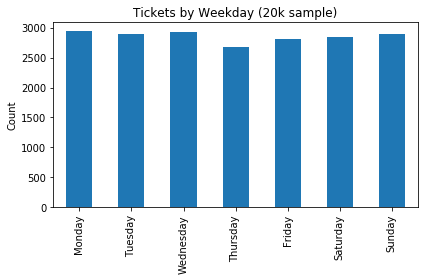

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_by_weekday.png


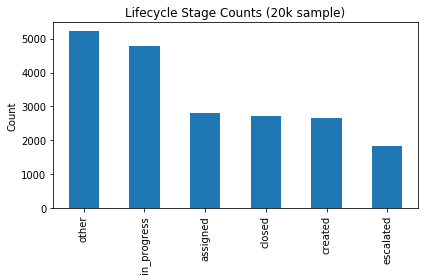

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_lifecycle.png


In [19]:
# ---------------------------------------------
# STEP 6B – Clean time & lifecycle charts (no unsupported pandas options)
# Requires: per_day_df, by_hour_df, by_weekday_df, lifecycle_df already defined
# ---------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ---- DAILY with 7-day rolling average ----
_per = per_day_df.copy()
_per["date"] = pd.to_datetime(_per["date"])
start, end = _per["date"].min(), _per["date"].max()
days = (end - start).days

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(_per["date"], _per["tickets"], linewidth=0.8, alpha=0.5, label="Daily")
_per["roll7"] = _per["tickets"].rolling(7, min_periods=1).mean()
ax.plot(_per["date"], _per["roll7"], linewidth=2, label="7-day avg")

# dynamic tick spacing
if days <= 120:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
else:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45, ha="right")
ax.set_title("Tickets per Day (20k sample)")
ax.set_ylabel("Count")
ax.grid(True, axis="y", linestyle="--", alpha=0.3)
ax.legend(loc="upper left", frameon=False)
plt.tight_layout()
out_daily = IMG_DIR / "kpi_tickets_per_day.png"
plt.savefig(out_daily, dpi=160); plt.show()
print("Saved:", out_daily)

# ---- WEEKLY roll-up (clear long-range view) ----
weekly = (_per.set_index("date")
              .resample("W-MON", label="left")
              .sum()
              .reset_index())

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(weekly["date"], weekly["tickets"], linewidth=2)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")
ax.set_title("Tickets per Week (20k sample)")
ax.set_ylabel("Count")
ax.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
out_weekly = IMG_DIR / "kpi_tickets_per_week.png"
plt.savefig(out_weekly, dpi=160); plt.show()
print("Saved:", out_weekly)

# ---- Hour, Weekday, Lifecycle (reuse your existing save_bar) ----
save_bar(by_hour_df, "hour", "tickets", "Tickets by Hour of Day (20k sample)", "kpi_by_hour.png")
save_bar(by_weekday_df, "weekday", "tickets", "Tickets by Weekday (20k sample)", "kpi_by_weekday.png")
save_bar(lifecycle_df, "event_stage", "events", "Lifecycle Stage Counts (20k sample)", "kpi_lifecycle.png")


In [16]:
# ---------------------------------------------
# STEP 7: Customer Satisfaction
# ---------------------------------------------

# 7.1 Distribution
cs_dist_sql = """
SELECT customer_satisfaction AS score, COUNT(*) AS n
FROM tickets_sample
WHERE customer_satisfaction IS NOT NULL
GROUP BY customer_satisfaction
ORDER BY score;
"""
cs_dist_df = run_sql("10_cs_distribution", cs_dist_sql)

# 7.2 Avg CS by Priority
cs_by_priority_sql = """
SELECT priority, ROUND(AVG(customer_satisfaction),2) AS avg_cs, COUNT(*) AS n
FROM tickets_sample
WHERE customer_satisfaction IS NOT NULL
GROUP BY priority
ORDER BY avg_cs DESC;
"""
cs_by_priority_df = run_sql("11_cs_by_priority", cs_by_priority_sql)

# 7.3 Avg CS by Channel
cs_by_channel_sql = """
SELECT report_channel, ROUND(AVG(customer_satisfaction),2) AS avg_cs, COUNT(*) AS n
FROM tickets_sample
WHERE customer_satisfaction IS NOT NULL
GROUP BY report_channel
ORDER BY avg_cs DESC;
"""
cs_by_channel_df = run_sql("12_cs_by_channel", cs_by_channel_sql)

print("=== CS Distribution ==="); print(cs_dist_df, "\n")
print("=== CS by Priority ==="); print(cs_by_priority_df, "\n")
print("=== CS by Channel ===");  print(cs_by_channel_df, "\n")

=== CS Distribution ===
   score     n
0      1  2391
1      2  2370
2      3  6239
3      4  6517
4      5  2483 

=== CS by Priority ===
  priority  avg_cs     n
0   Medium    3.24  9962
1     High    3.21  4057
2      Low    3.19  5981 

=== CS by Channel ===
  report_channel  avg_cs      n
0            App    3.26   1191
1          Phone    3.25    571
2        Website    3.22  10672
3          Email    3.21   7566 



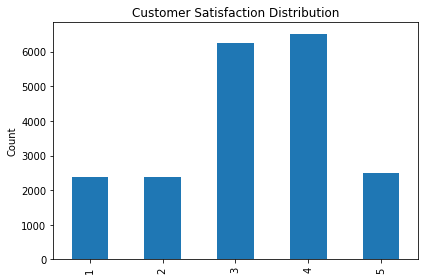

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_cs_distribution.png


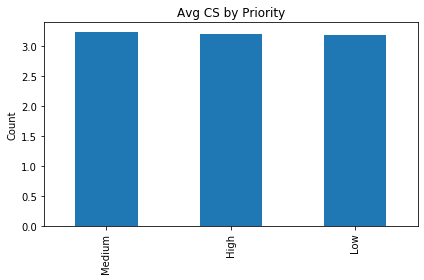

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_cs_by_priority.png


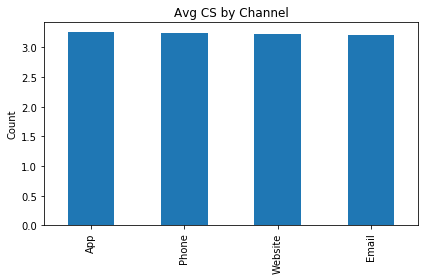

🖼️  Saved: C:\Users\Dhairr\Dhairya Projects\bugtracker-ict-analytics\images\kpi_cs_by_channel.png


In [17]:
save_bar(cs_dist_df, "score", "n", "Customer Satisfaction Distribution", "kpi_cs_distribution.png")
save_bar(cs_by_priority_df, "priority", "avg_cs", "Avg CS by Priority", "kpi_cs_by_priority.png")
save_bar(cs_by_channel_df, "report_channel", "avg_cs", "Avg CS by Channel", "kpi_cs_by_channel.png")

In [20]:
print("SAMPLE SIZE:", pd.read_sql_query("SELECT COUNT(*) n FROM tickets_sample;", conn)["n"][0])
print("DATE RANGE:", per_day_df["date"].min(), "to", per_day_df["date"].max())

SAMPLE SIZE: 20000
DATE RANGE: 2023-01-01 to 2024-01-01
